In [1]:
import numpy as np
from scipy import linalg
import pymc3 as pm
import matplotlib.pylab as plt
import seaborn as sns

aseyboldt [9:30 PM]
I just had a nice idea about estimating dense mass matrices during NUTS tuning. We could just use the covariance matrix of the samples. But we actually have a second source of information: the gradients. Their inner product converges to the inverse of the covariance matrix.
At least for the case of `n_params < n_tuning` we can just use the fact that log(C) for symmetric positive definite matrices gives us a flat manifold, and use the mean of our two covariance estimates. This seems to give much better estimates:

Text(0.5,1,'The correlation matrix of the posterior')

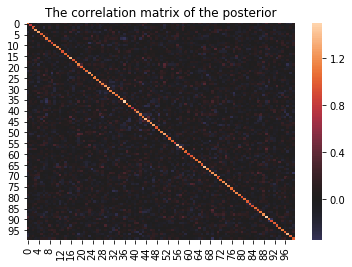

In [2]:
N = 100
A = np.random.randn(N, N)
C = A @ A.T / N + 0.1 * np.eye(N)

sns.heatmap(C, center=0)
plt.title('The correlation matrix of the posterior');

In [3]:
with pm.Model() as model:
    pm.MvNormal('a', mu=np.zeros(N), cov=C, shape=N)
    trace = pm.sample()

M = len(trace)
grads = []
func = model.logp_dlogp_function()
func.set_extra_values({})
for point in trace:
    grads.append(func(func.dict_to_array(point))[1])

grads = np.array(grads)[:M]
vals = trace['a'][:M]

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a]
Sampling 2 chains: 100%|██████████| 2000/2000 [00:06<00:00, 303.96draws/s]


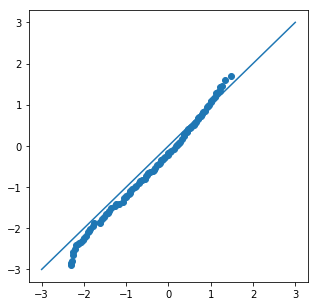

In [4]:
_, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.scatter(np.log(linalg.eigvalsh(C)), np.log(linalg.eigvalsh(np.cov(vals.T))))
ax.plot([-3, 3], [-3, 3]);

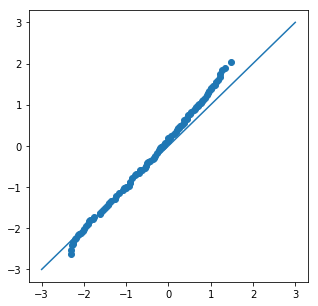

In [5]:
_, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.scatter(np.log(linalg.eigvalsh(C)), np.log(1 / linalg.eigvalsh(np.cov(grads.T))[::-1]))
ax.plot([-3, 3], [-3, 3]);

Both are somewhat bad for small and high eigenvalues.
We can do better with the mean of log scale:

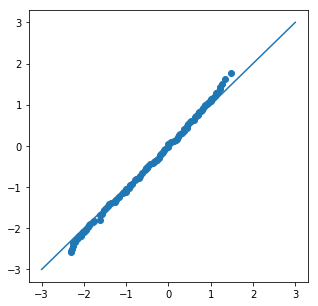

In [6]:
F = linalg.expm(0.5 * linalg.logm(np.cov(vals.T)) + 0.5 * linalg.logm(linalg.inv(np.cov(grads.T))))
_, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.scatter(np.log(linalg.eigvalsh(C)), np.log(linalg.eigvalsh(F)))
ax.plot([-3, 3], [-3, 3]);

That doesn’t seem to only apply to the eigenvalues, but to the whole covariance matrix:

In [7]:
linalg.norm(C - F)

5.411868493726521

In [8]:
linalg.norm(C - np.cov(vals.T))

6.400203915581729